In [1]:
# Load libraries
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
from keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.utils import np_utils
import random
from keras.preprocessing import image, sequence
import matplotlib.pyplot as plt

In [2]:
images_dir = os.listdir("Projet")

images_path = 'Projet/Dataset/'
captions_path = 'Projet/Text/Flickr8k.token.txt'
train_path = 'Projet/Text/Flickr_8k.trainImages.txt'
val_path = 'Projet/Text/Flickr_8k.devImages.txt'
test_path = 'Projet/Text/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [3]:
# Loading captions as values and images as key in dictionary
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

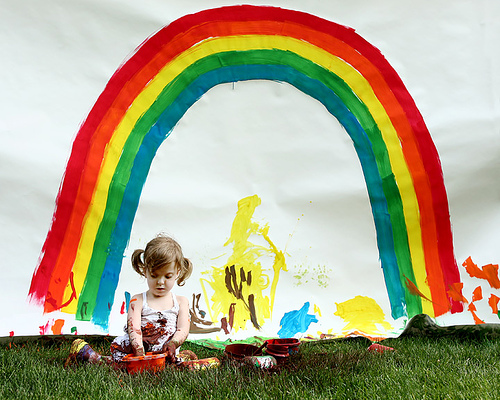

A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A little girl is sitting in front of a large painted rainbow .
A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
There is a girl with pigtails sitting in front of a rainbow painting .
Young girl with pigtails painting outside in the grass .


In [4]:
# displaying an image and captions given to it
temp = captions[10].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

In [5]:
# Creating train, test and validation dataset files with header as 'image_id' and 'captions'
train_dataset = open('flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

18

In [6]:
# Populating the above created files for train, test and validation dataset with image ids and captions for each of these images
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write((img+"\t"+caption+"\n").encode())
        train_dataset.flush()
train_dataset.close()

for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
test_dataset.close()

for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

In [7]:
# Loading 50 layer Residual Network Model and getting the summary of the model
from IPython.core.display import display, HTML
display(HTML("""<a href="http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006">ResNet50 Architecture</a>"""))
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
model.summary()
# Note: For more details on ResNet50 architecture you can click on hyperlink given below

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [8]:
# Helper function to process images
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [9]:
train_data = {}
ctr=0
for ix in x_train:
    if ix == "":
        continue
    if ctr >= 3000:
        break
    ctr+=1
    if ctr%1000==0:
        print(ctr)
    path = images_path + ix
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    train_data[ix] = pred

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-b89d7f393d62>", line 13, in <module>
    pred = model.predict(img).reshape(2048)
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\keras\engine\training.py", line 1982, in predict
    tmp_batch_outputs = self.predict_function(iterator)
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py", line 915, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\tenso

TypeError: object of type 'NoneType' has no len()

In [69]:
train_data['2513260012_03d33305cf.jpg'].shape

(2048,)

In [70]:
# opening train_encoded_images.p file and dumping it's content
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_data, pickle_f )  

In [71]:
# Loading image and its corresponding caption into a dataframe and then storing values from dataframe into 'ds'
pd_dataset = pd.read_csv("flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print(ds.shape)

(30000, 2)


In [72]:
pd_dataset.head()

,image_id,captions
0,2513260012_03d33305cf.jpg,<start> A black dog is running after a white d...
1,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
2,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
3,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
4,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...


In [73]:
# Storing all the captions from ds into a list
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print(len(sentences))

30000


In [74]:
# First 5 captions stored in sentences
sentences[:5]

['<start> A black dog is running after a white dog in the snow . <end>',
 '<start> Black dog chasing brown dog through snow <end>',
 '<start> Two dogs chase each other across the snowy ground . <end>',
 '<start> Two dogs play together in the snow . <end>',
 '<start> Two dogs running through a low lying body of water . <end>']

In [75]:
words = [i.split() for i in sentences]

In [76]:
# Creating a list of all unique words
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

print(len(unique))

vocab_size = len(unique)

8253


In [77]:
# Vectorization
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [78]:
word_2_indices['UNK'] = 0
word_2_indices['raining'] = 8253

In [79]:
indices_2_word[0] = 'UNK'
indices_2_word[8253] = 'raining'

In [80]:
print(word_2_indices['<start>'])
print(indices_2_word[4011])
print(word_2_indices['<end>'])
print(indices_2_word[8051])

8052
Vendor
1347
sell


In [81]:
vocab_size = len(word_2_indices.keys())
print(vocab_size)

8254


In [82]:
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)

40


In [83]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

<ipython-input-83-0b0e4eb81386>:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)


(30000,)
(30000,)


<ipython-input-83-0b0e4eb81386>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  padded_sequences = np.asarray(padded_sequences)
<ipython-input-83-0b0e4eb81386>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subsequent_words = np.asarray(subsequent_words)


In [84]:
print(padded_sequences[0])

[[8052    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [8052 2919    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [8052 2919 2287    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [8052 2919 2287 4322    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [8052 2919 2287 4322 5791    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [85]:
for ix in range(len(padded_sequences[0])):
    for iy in range(max_len):
        print(indices_2_word[padded_sequences[0][ix][iy]],)
    print("\n")

print(len(padded_sequences[0]))

<start>
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
running
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<sta

In [86]:
num_of_images = 2000

In [87]:
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

In [88]:
for ix in range(num_of_images):#img_to_padded_seqs.shape[0]):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("captions.npy", captions)
np.save("next_words.npy", next_words)

print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


In [100]:
with open('train_encoded_images.p', 'rb') as f:
    encoded_images = pickle.load(f, encoding="bytes")

In [104]:
imgs = []

for ix in range(ds.shape[0]):
    if ds[ix, 0] in encoded_images.keys():
        #print(ix, encoded_images[ds[ix, 0].encode()])
        imgs.append(list(encoded_images[ds[ix, 0]]))

imgs = np.asarray(imgs)
print(imgs.shape)

(15000, 2048)


In [105]:
images = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

np.save("images.npy", images)

print(images.shape)

(25493, 2048)


In [106]:
image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
image_names = np.asarray(image_names)

np.save("image_names.npy", image_names)

print(len(image_names))

25493


In [107]:
captions = np.load("captions.npy")
next_words = np.load("next_words.npy")

print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


In [108]:
images = np.load("images.npy")

print(images.shape)

(25493, 2048)


In [109]:
imag = np.load("image_names.npy")
        
print(imag.shape)

(25493,)


In [110]:
embedding_size = 128
max_len = 40

In [111]:
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVector  (None, 40, 128)          0         
 )                                                               
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [112]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           1056512   
                                                                 
 lstm (LSTM)                 (None, 40, 256)           394240    
                                                                 
 time_distributed (TimeDistr  (None, 40, 128)          32896     
 ibuted)                                                         
                                                                 
Total params: 1,483,648
Trainable params: 1,483,648
Non-trainable params: 0
_________________________________________________________________


In [113]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 40)]         0           []                               
                                                                                                  
 dense_input (InputLayer)       [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      1056512     ['embedding_input[0][0]']        
                                                                                                  
 dense (Dense)                  (None, 128)          262272      ['dense_input[0][0]']            
                                                                                              

In [148]:
hist = model.fit([images, captions], next_words, batch_size=512, epochs=200)

Epoch 1/200
50/50 [==============================] - 253s 5s/step - loss: 1.9991 - accuracy: 0.4333
Epoch 2/200
50/50 [==============================] - 170s 3s/step - loss: 1.9509 - accuracy: 0.4412
Epoch 3/200
50/50 [==============================] - 175s 4s/step - loss: 1.8996 - accuracy: 0.4536
Epoch 4/200
50/50 [==============================] - 175s 3s/step - loss: 1.8605 - accuracy: 0.4596
Epoch 5/200
50/50 [==============================] - 194s 4s/step - loss: 1.8186 - accuracy: 0.4659
Epoch 6/200
50/50 [==============================] - 255s 5s/step - loss: 1.7923 - accuracy: 0.4679
Epoch 7/200
50/50 [==============================] - 276s 6s/step - loss: 1.7557 - accuracy: 0.4765
Epoch 8/200
50/50 [==============================] - 281s 6s/step - loss: 1.7138 - accuracy: 0.4865
Epoch 9/200
50/50 [==============================] - 288s 6s/step - loss: 1.6790 - accuracy: 0.4915
Epoch 10/200
50/50 [==============================] - 269s 5s/step - loss: 1.6422 - accuracy: 0.4988

50/50 [==============================] - 161s 3s/step - loss: 0.2480 - accuracy: 0.9031
Epoch 163/200
50/50 [==============================] - 160s 3s/step - loss: 0.2471 - accuracy: 0.9038
Epoch 164/200
50/50 [==============================] - 160s 3s/step - loss: 0.2559 - accuracy: 0.9001
Epoch 165/200
50/50 [==============================] - 159s 3s/step - loss: 0.2423 - accuracy: 0.9044
Epoch 166/200
50/50 [==============================] - 160s 3s/step - loss: 0.2465 - accuracy: 0.9049
Epoch 167/200
50/50 [==============================] - 159s 3s/step - loss: 0.2449 - accuracy: 0.9030
Epoch 168/200
50/50 [==============================] - 159s 3s/step - loss: 0.2414 - accuracy: 0.9055
Epoch 169/200
50/50 [==============================] - 159s 3s/step - loss: 0.2460 - accuracy: 0.9042
Epoch 170/200
50/50 [==============================] - 159s 3s/step - loss: 0.2395 - accuracy: 0.9051
Epoch 171/200
50/50 [==============================] - 159s 3s/step - loss: 0.2426 - accuracy: 0

In [149]:
model.save_weights("model_weights.h5")


In [150]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [151]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [152]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [1]:
img = "Projet/Dataset/111766423_4522d36e56.jpg"

test_img = get_encoding(resnet, img)

NameError: name 'get_encoding' is not defined

In [157]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)

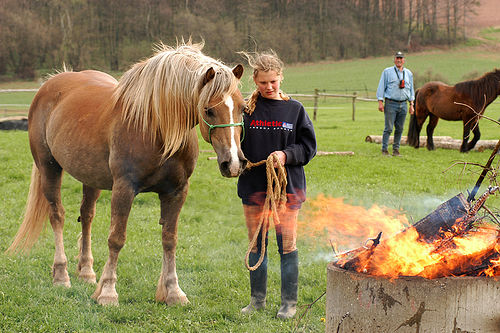

Two elephant wearing a colorful blue and blue blue walking along the road .


In [158]:
z = Image(filename=img)
display(z)

print(Argmax_Search)

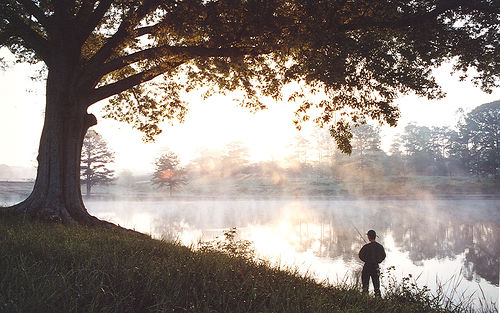

A surfer is in a high wave on a wave .


In [155]:
z = Image(filename=img)
display(z)

print(Argmax_Search)